In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# set up data paths

base_dir = './'
healthy_dir = os.path.join(base_dir, 'HEALTHY_1')
unhealthy_dir = os.path.join(base_dir, 'BLACK SIGATOKA_1')

# set up data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# create the model

base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train the model

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

# After training your model
model.save('banana_health_classifier_mobilenet.h5')

Found 4445 images belonging to 2 classes.
Found 1111 images belonging to 2 classes.
Epoch 1/20
138/138 [==============================] - 119s 809ms/step - loss: 0.1375 - accuracy: 0.9567 - val_loss: 0.0429 - val_accuracy: 0.9899
Epoch 2/20
138/138 [==============================] - 105s 763ms/step - loss: 0.0481 - accuracy: 0.9884 - val_loss: 0.0259 - val_accuracy: 0.9945
Epoch 3/20
138/138 [==============================] - 105s 764ms/step - loss: 0.0320 - accuracy: 0.9918 - val_loss: 0.0221 - val_accuracy: 0.9963
Epoch 4/20
138/138 [==============================] - 103s 747ms/step - loss: 0.0283 - accuracy: 0.9930 - val_loss: 0.0204 - val_accuracy: 0.9926
Epoch 5/20
138/138 [==============================] - 104s 753ms/step - loss: 0.0241 - accuracy: 0.9957 - val_loss: 0.0205 - val_accuracy: 0.9954
Epoch 6/20
138/138 [==============================] - 101s 733ms/step - loss: 0.0204 - accuracy: 0.9959 - val_loss: 0.0193 - val_accuracy: 0.9963
Epoch 7/20
138/138 [====================

1/1 [==============================] - 0s 23ms/step


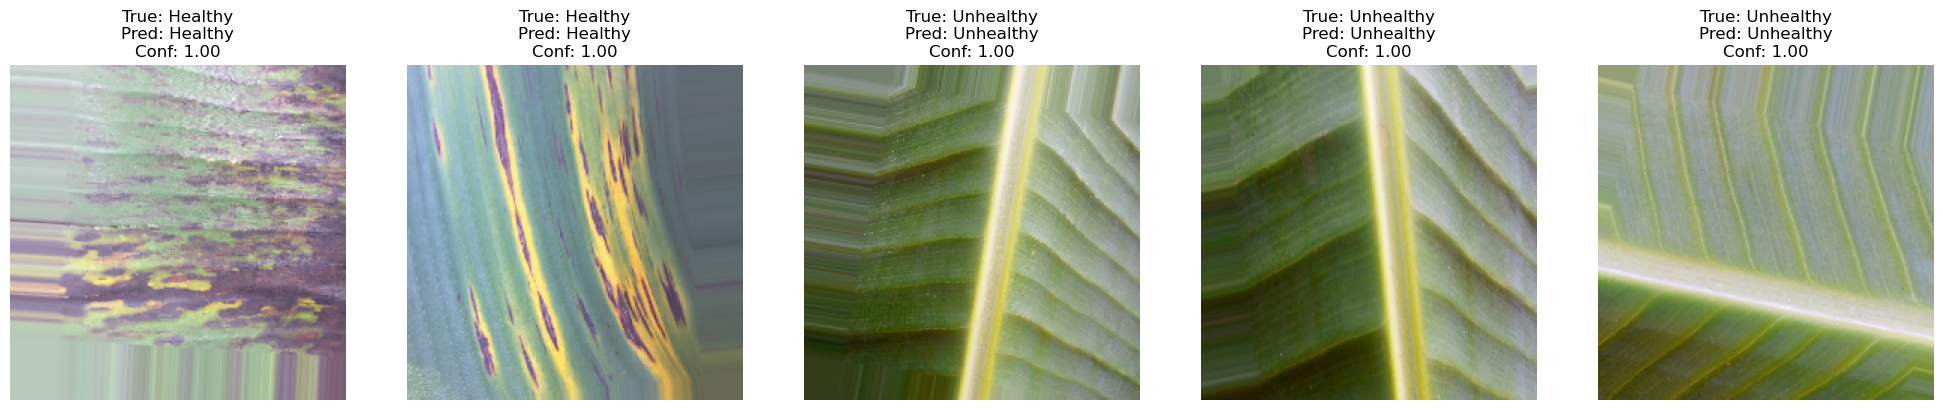

Sample 1:
True Label: Unhealthy
Predicted Label: Unhealthy
Confidence: 1.00
Correct: True

Sample 2:
True Label: Unhealthy
Predicted Label: Unhealthy
Confidence: 1.00
Correct: True

Sample 3:
True Label: Healthy
Predicted Label: Healthy
Confidence: 1.00
Correct: True

Sample 4:
True Label: Healthy
Predicted Label: Healthy
Confidence: 1.00
Correct: True

Sample 5:
True Label: Healthy
Predicted Label: Healthy
Confidence: 1.00
Correct: True



In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Function to get a batch of images from the validation generator
def get_val_samples(num_samples):
    val_batch = next(val_generator)
    images, labels = val_batch
    
    # Randomly select num_samples from the batch
    indices = random.sample(range(len(images)), num_samples)
    return images[indices], labels[indices]

# Number of samples to test
num_samples = 5

# Get random samples from validation set
test_images, true_labels = get_val_samples(num_samples)

# Make predictions
predictions = model.predict(test_images)

# Plot the results
fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
for i in range(num_samples):
    ax = axes[i]
    ax.imshow(test_images[i])
    
    true_label = "Healthy" if true_labels[i] < 0.5 else "Unhealthy"
    pred_label = "Healthy" if predictions[i] < 0.5 else "Unhealthy"
    confidence = predictions[i][0] if predictions[i] >= 0.5 else 1 - predictions[i][0]
    
    ax.set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Print detailed results
for i in range(num_samples):
    true_label = "Unhealthy" if true_labels[i] < 0.5 else "Healthy"
    pred_label = "Unhealthy" if predictions[i] < 0.5 else "Healthy"
    confidence = predictions[i][0] if predictions[i] >= 0.5 else 1 - predictions[i][0]
    
    print(f"Sample {i+1}:")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {pred_label}")
    print(f"Confidence: {confidence:.2f}")
    print(f"Correct: {true_label == pred_label}")
    print()

1/1 [==============================] - 0s 31ms/step


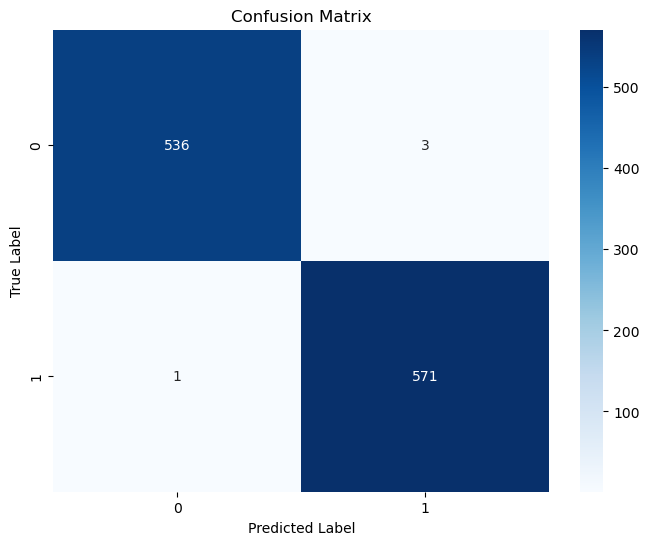

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to get predictions and true labels for the entire validation set
def get_val_predictions():
    val_generator.reset()
    y_true = []
    y_pred = []
    
    for i in range(len(val_generator)):
        x, y = val_generator[i]
        y_true.extend(y)
        y_pred.extend(model.predict(x).flatten())
    
    return np.array(y_true), np.array(y_pred)

# Get predictions and true labels
y_true, y_pred_prob = get_val_predictions()

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [12]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Unhealthy']))

# Calculate and print additional metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc_roc = roc_auc_score(y_true, y_pred_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")


Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      0.99      1.00       539
   Unhealthy       0.99      1.00      1.00       572

    accuracy                           1.00      1111
   macro avg       1.00      1.00      1.00      1111
weighted avg       1.00      1.00      1.00      1111

Accuracy: 0.9964
Precision: 0.9948
Recall: 0.9983
F1 Score: 0.9965
AUC-ROC: 0.9999


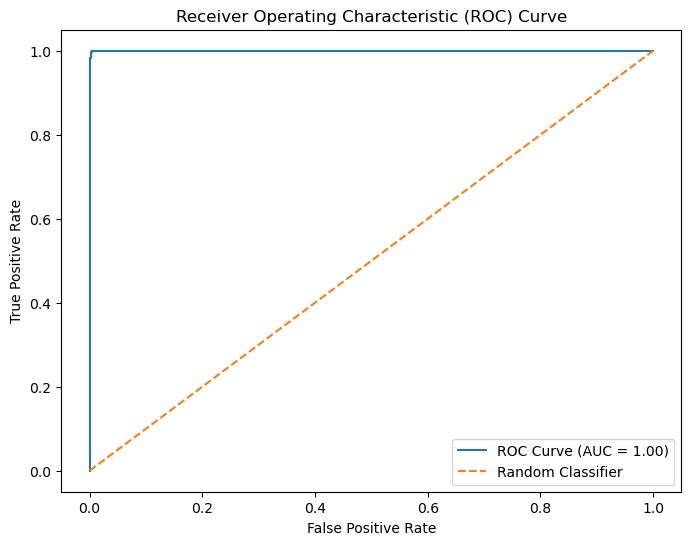

In [13]:
# Plot ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [14]:
# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('banana_health_classifier_mobilenet.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\imoua\AppData\Local\Temp\tmpr966_s26\assets


INFO:tensorflow:Assets written to: C:\Users\imoua\AppData\Local\Temp\tmpr966_s26\assets
